In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression
from matplotlib_venn import venn2 
from sklearn.model_selection import KFold

In [2]:
def preprocessing(df):
    df_1 = df.fillna(round(df.median(),1))  
    
    df_feature = df_1.iloc[:, 2:]
    df_label = df_1.iloc[:, 1]
    cols = df_feature.columns
    
    ### scale df_feature & df_label
    scaler = MinMaxScaler()
    df_x = scaler.fit_transform(df_feature)
    encoder = LabelEncoder()
    df_y = encoder.fit_transform(np.array(df_label).reshape(-1,1))
    
    return df_x, df_y, cols

In [3]:
def model_fi(df_x, df_y, cols, cv):
    fi_list = []
    loss_list = []
    for train_index, test_index in cv.split(df_x):
        X_train, X_test, y_train, y_test = df_x[train_index], df_x[test_index], df_y[train_index], df_y[test_index]
        eval_set = [(X_test, y_test)]
    
        xgbc.fit(X_train, y_train, eval_set=eval_set, verbose=False)
        fi_list.append(xgbc.feature_importances_)
        loss_list.append(xgbc.evals_result())

    loss_last_one_list = []
    for i in loss_list:
        loss_last_one_list.append(i["validation_0"]["logloss"][-1])

    loss_last_one_df = pd.DataFrame(loss_last_one_list)
    loss_last_one_df.columns = ["Loss"]
    fi_best = loss_last_one_df.sort_values(["Loss"], ascending=True).index[0]

    model_fi = fi_list[fi_best]
    model_fi_df = pd.DataFrame([cols,model_fi]).T
    model_fi_df.columns = (["Feature", "Value"])
    model_fi_df = model_fi_df.sort_values(["Value"], ascending=False)
    model_fi_df = model_fi_df.reset_index(drop=True)    
    
    return model_fi_df

In [4]:
def model_fi_auc(model_fi_df, df_x, df_y, cols):
    model_fi_non_zero = model_fi_df[model_fi_df != 0]
    model_fi_non_zero = model_fi_non_zero.dropna()

    auc_fi_list = []
    for i in list(range(1,len(model_fi_non_zero)+1)):
        model_fi_index = model_fi_non_zero["Feature"][0:i]
        auc_list = []
        for train_index, test_index in loocv.split(df_x):
            X_train, X_test, y_train, y_test = df_x[train_index], df_x[test_index], df_y[train_index], df_y[test_index]
            X_train = pd.DataFrame(X_train)
            X_train.columns=cols
            X_test = pd.DataFrame(X_test)
            X_test.columns=cols
            
            X_train_selected = X_train[model_fi_index]
            X_test_selected = X_test[model_fi_index]

            xgbc.fit(X_train_selected, y_train)
            y_test_pred = xgbc.predict_proba(X_test_selected)
            auc_list.append(y_test_pred[:,1])
        fpr, tpr, thresholds = roc_curve(df_y, pd.DataFrame(auc_list))
        test_auroc_selected_tuned = auc(fpr, tpr)
        auc_fi_list.append(test_auroc_selected_tuned)
    
    return auc_fi_list

In [5]:
def model_pvalue(df_x, df_y, cols):
    f_values, p_values = f_regression(df_x, df_y)
    df_pvalue = pd.DataFrame([cols,p_values]).T
    df_pvalue.columns = ["Feature", "P-value"]
    df_pvalue = df_pvalue.sort_values(["P-value"], ascending=True)
    df_pvalue = df_pvalue.reset_index(drop=True)

    auc_pvalue_list = []
    for i in list(range(1,31)):
        df_pvalue_index = df_pvalue["Feature"][0:i]
        auc_list = []
        for train_index, test_index in loocv.split(df_x):
            X_train, X_test, y_train, y_test = df_x[train_index], df_x[test_index], df_y[train_index], df_y[test_index]
            X_train = pd.DataFrame(X_train)
            X_train.columns=cols
            X_test = pd.DataFrame(X_test)
            X_test.columns=cols

            X_train_selected = X_train[df_pvalue_index]
            X_test_selected = X_test[df_pvalue_index]

            lr.fit(X_train_selected, y_train)
            y_test_pred = lr.predict_proba(X_test_selected)
            auc_list.append(y_test_pred[:,1])
        fpr, tpr, thresholds = roc_curve(df_y, pd.DataFrame(auc_list))
        test_auroc_selected_tuned = auc(fpr, tpr)
        auc_pvalue_list.append(test_auroc_selected_tuned)    
    
    return df_pvalue, auc_pvalue_list

In [6]:
def Intersected_Feature_AUC(df, model, set1, set2):
    df_1 = df.fillna(round(df.median(),1))  
    
    df_feature = df_1[set1 & set2]
    df_label = df_1.iloc[:, 1]
    cols = df_feature.columns
    
    ### scale df_feature & df_label
    scaler = MinMaxScaler()
    df_x = scaler.fit_transform(df_feature)
    encoder = LabelEncoder()
    df_y = encoder.fit_transform(np.array(df_label).reshape(-1,1))
    
    ### LOOCV
    auc_list = []
    for train_index, test_index in loocv.split(df_x):
        X_train, X_test, y_train, y_test = df_x[train_index], df_x[test_index], df_y[train_index], df_y[test_index]
    
        model.fit(X_train, y_train)
        y_test_pred = model.predict_proba(X_test)
        auc_list.append(y_test_pred[:,1])
    fpr, tpr, thresholds = roc_curve(df_y, pd.DataFrame(auc_list))
    test_auroc_tuned = auc(fpr, tpr)
    print('AUC of testing set:', test_auroc_tuned)

## Preload Variables

In [7]:
xgbc = XGBClassifier(random_state=19, use_label_encoder=False, eval_metric="logloss")
lr = LogisticRegression(random_state=19)
loocv = LeaveOneOut()
kfold = KFold(3, True, 19)

## Analyse data sets

In [8]:
lipid_short = pd.read_csv("LIPID_short.csv")
lipid_short_X, lipid_short_y, lipid_short_cols = preprocessing(lipid_short)
lipid_short_fi = model_fi(lipid_short_X, lipid_short_y, lipid_short_cols, loocv)
lipid_short_fi_auc = model_fi_auc(lipid_short_fi, lipid_short_X, lipid_short_y, lipid_short_cols)
lipid_short_pvalue, lipid_short_pvalue_auc = model_pvalue(lipid_short_X, lipid_short_y, lipid_short_cols)

In [9]:
lipid_long = pd.read_csv("LIPID_long.csv")
lipid_long = lipid_long.drop(["File_Name_LP"], axis = 1)
lipid_long_X, lipid_long_y, lipid_long_cols = preprocessing(lipid_long)
lipid_long_fi = model_fi(lipid_long_X, lipid_long_y, lipid_long_cols, loocv)
lipid_long_fi_auc = model_fi_auc(lipid_long_fi, lipid_long_X, lipid_long_y, lipid_long_cols)
lipid_long_pvalue, lipid_long_pvalue_auc = model_pvalue(lipid_long_X, lipid_long_y, lipid_long_cols)

In [10]:
meta_short = pd.read_csv("Meta_short.csv")
meta_short_X, meta_short_y, meta_short_cols = preprocessing(meta_short)
meta_short_fi = model_fi(meta_short_X, meta_short_y, meta_short_cols, loocv)
meta_short_fi_auc = model_fi_auc(meta_short_fi, meta_short_X, meta_short_y, meta_short_cols)
meta_short_pvalue, meta_short_pvalue_auc = model_pvalue(meta_short_X, meta_short_y, meta_short_cols)

In [11]:
meta_long = pd.read_csv("Meta_long.csv")
meta_long = meta_long.drop(["File_Name_MP"], axis = 1)
meta_long_X, meta_long_y, meta_long_cols = preprocessing(meta_long)
meta_long_fi = model_fi(meta_long_X, meta_long_y, meta_long_cols, loocv)
meta_long_fi_auc = model_fi_auc(meta_long_fi, meta_long_X, meta_long_y, meta_long_cols)
meta_long_pvalue, meta_long_pvalue_auc = model_pvalue(meta_long_X, meta_long_y, meta_long_cols)

## AUC of Feature Importance

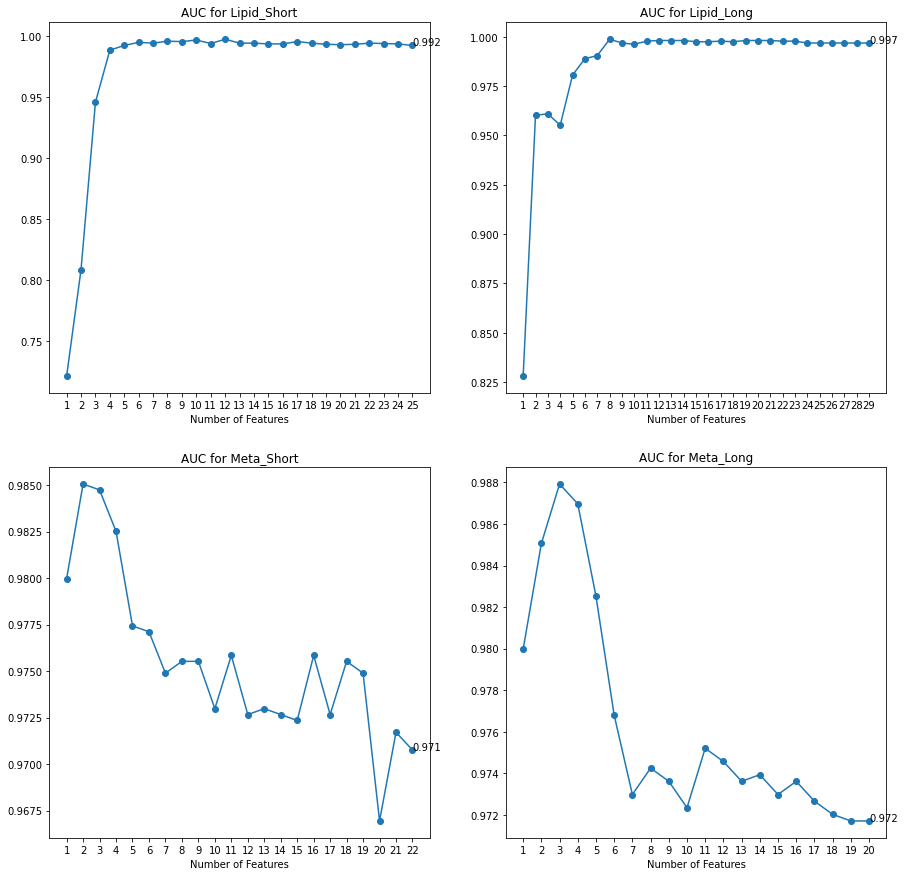

In [12]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15,15))

ax[0,0].plot(list(range(1,len(lipid_short_fi_auc)+1)), lipid_short_fi_auc)
ax[0,0].scatter(list(range(1,len(lipid_short_fi_auc)+1)), lipid_short_fi_auc)
ax[0,0].annotate(round(lipid_short_fi_auc[-1], 3), (list(range(1,len(lipid_short_fi_auc)+1))[-1], lipid_short_fi_auc[-1]))
ax[0,0].title.set_text('AUC for Lipid_Short')
ax[0,0].set_xlabel('Number of Features')
ax[0,0].set_xticks(list(range(1,len(lipid_short_fi_auc)+1))) 

ax[0,1].plot(list(range(1,len(lipid_long_fi_auc)+1)), lipid_long_fi_auc)
ax[0,1].scatter(list(range(1,len(lipid_long_fi_auc)+1)), lipid_long_fi_auc)
ax[0,1].annotate(round(lipid_long_fi_auc[-1], 3), (list(range(1,len(lipid_long_fi_auc)+1))[-1], lipid_long_fi_auc[-1]))
ax[0,1].title.set_text('AUC for Lipid_Long')
ax[0,1].set_xlabel('Number of Features')
ax[0,1].set_xticks(list(range(1,len(lipid_long_fi_auc)+1))) 

ax[1,0].plot(list(range(1,len(meta_short_fi_auc)+1)), meta_short_fi_auc)
ax[1,0].scatter(list(range(1,len(meta_short_fi_auc)+1)), meta_short_fi_auc)
ax[1,0].annotate(round(meta_short_fi_auc[-1], 3), (list(range(1,len(meta_short_fi_auc)+1))[-1], meta_short_fi_auc[-1]))
ax[1,0].title.set_text('AUC for Meta_Short')
ax[1,0].set_xlabel('Number of Features')
ax[1,0].set_xticks(list(range(1,len(meta_short_fi_auc)+1))) 

ax[1,1].plot(list(range(1,len(meta_long_fi_auc)+1)), meta_long_fi_auc)
ax[1,1].scatter(list(range(1,len(meta_long_fi_auc)+1)), meta_long_fi_auc)
ax[1,1].annotate(round(meta_long_fi_auc[-1], 3), (list(range(1,len(meta_long_fi_auc)+1))[-1], meta_long_fi_auc[-1]))
ax[1,1].title.set_text('AUC for Meta_Long')
ax[1,1].set_xlabel('Number of Features')
ax[1,1].set_xticks(list(range(1,len(meta_long_fi_auc)+1))) 

plt.show()

## AUC of P-Value

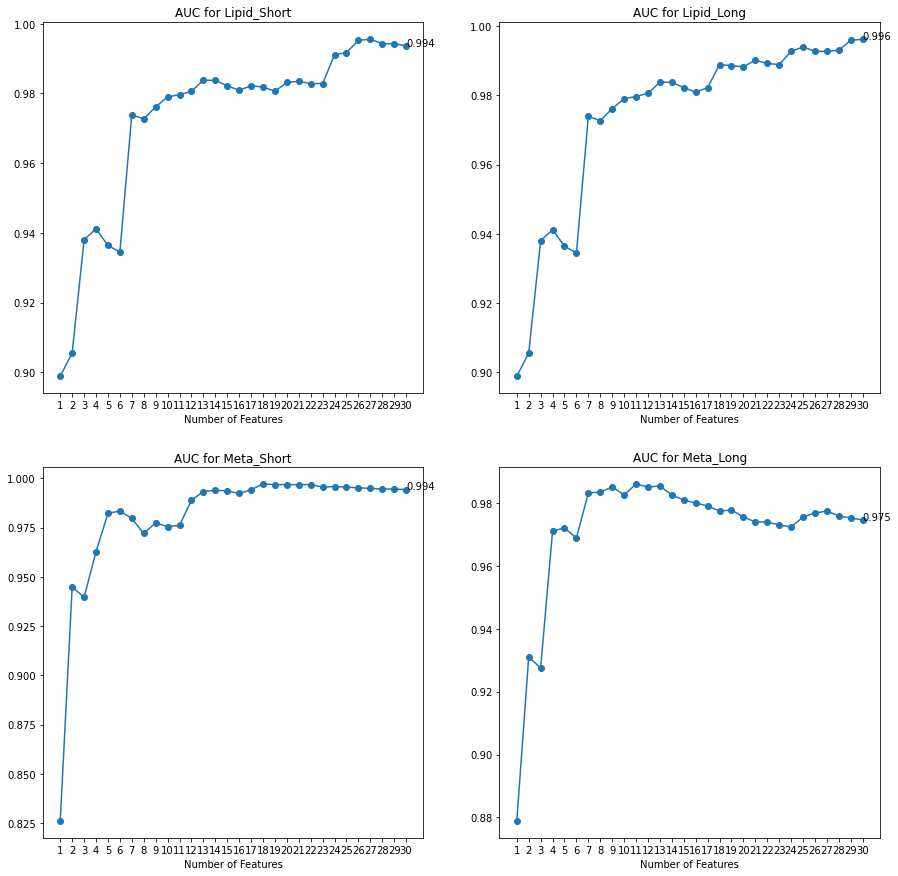

In [13]:
x = list(range(1,31))
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15,15))

ax[0,0].plot(x, lipid_short_pvalue_auc)
ax[0,0].scatter(x, lipid_short_pvalue_auc)
ax[0,0].annotate(round(lipid_short_pvalue_auc[-1], 3), (x[-1], lipid_short_pvalue_auc[-1]))
ax[0,0].title.set_text('AUC for Lipid_Short')
ax[0,0].set_xlabel('Number of Features')
ax[0,0].set_xticks(x) 

ax[0,1].plot(x, lipid_long_pvalue_auc)
ax[0,1].scatter(x, lipid_long_pvalue_auc)
ax[0,1].annotate(round(lipid_long_pvalue_auc[-1], 3), (x[-1], lipid_long_pvalue_auc[-1]))
ax[0,1].title.set_text('AUC for Lipid_Long')
ax[0,1].set_xlabel('Number of Features')
ax[0,1].set_xticks(x) 

ax[1,0].plot(x, meta_short_pvalue_auc)
ax[1,0].scatter(x, meta_short_pvalue_auc)
ax[1,0].annotate(round(meta_short_pvalue_auc[-1], 3), (x[-1], meta_short_pvalue_auc[-1]))
ax[1,0].title.set_text('AUC for Meta_Short')
ax[1,0].set_xlabel('Number of Features')
ax[1,0].set_xticks(x) 

ax[1,1].plot(x, meta_long_pvalue_auc)
ax[1,1].scatter(x, meta_long_pvalue_auc)
ax[1,1].annotate(round(meta_long_pvalue_auc[-1], 3), (x[-1], meta_long_pvalue_auc[-1]))
ax[1,1].title.set_text('AUC for Meta_Long')
ax[1,1].set_xlabel('Number of Features')
ax[1,1].set_xticks(x) 

plt.show()

## Save files

In [14]:
lipid_short_fi["AUC"] = pd.Series(lipid_short_fi_auc)
lipid_short_fi["AUC"][lipid_short_fi["AUC"].isna()]= ""
lipid_long_fi["AUC"] = pd.Series(lipid_long_fi_auc)
lipid_long_fi["AUC"][lipid_long_fi["AUC"].isna()]= ""
meta_short_fi["AUC"] = pd.Series(meta_short_fi_auc)
meta_short_fi["AUC"][meta_short_fi["AUC"].isna()]= ""
meta_long_fi["AUC"] = pd.Series(meta_long_fi_auc)
meta_long_fi["AUC"][meta_long_fi["AUC"].isna()]= ""

lipid_short_pvalue["AUC"] = pd.Series(lipid_short_pvalue_auc)
lipid_short_pvalue["AUC"][lipid_short_pvalue["AUC"].isna()]= ""
lipid_long_pvalue["AUC"] = pd.Series(lipid_long_pvalue_auc)
lipid_long_pvalue["AUC"][lipid_long_pvalue["AUC"].isna()]= ""
meta_short_pvalue["AUC"] = pd.Series(meta_short_pvalue_auc)
meta_short_pvalue["AUC"][meta_short_pvalue["AUC"].isna()]= ""
meta_long_pvalue["AUC"] = pd.Series(meta_long_pvalue_auc)
meta_long_pvalue["AUC"][meta_long_pvalue["AUC"].isna()]= ""

In [15]:
fi_df = pd.concat([lipid_short_fi, lipid_long_fi, meta_short_fi, meta_long_fi], axis=1)
fi_df[fi_df.isna()] = ""
fi_df.columns = ["Lipid_Short_Feature_Name", "Lipid_Short_Feature_Importance", "Lipid_Short_Accumulated_AUC",
                "Lipid_Long_Feature_Name", "Lipid_Long_Feature_Importance", "Lipid_Long_Accumulated_AUC",
                "Meta_Short_Feature_Name", "Meta_Short_Feature_Importance", "Meta_Short_Accumulated_AUC",
                "Meta_Long_Feature_Name", "Meta_Long_Feature_Importance", "Meta_Long_Accumulated_AUC"]
#fi_df.to_csv("Feature_importance.csv")

pvalue_df = pd.concat([lipid_short_pvalue, lipid_long_pvalue, meta_short_pvalue, meta_long_pvalue], axis=1)
pvalue_df[pvalue_df.isna()] = ""
pvalue_df.columns = ["Lipid_Short_Pvalue_Feature_Name", "Lipid_Short_Pvalue_Feature_Importance", "Lipid_Short_Pvalue_Accumulated_AUC",
                "Lipid_Long_Pvalue_Feature_Name", "Lipid_Long_Pvalue_Feature_Importance", "Lipid_Long_Pvalue_Accumulated_AUC",
                "Meta_Short_Pvalue_Feature_Name", "Meta_Short_Pvalue_Feature_Importance", "Meta_Short_Pvalue_Accumulated_AUC",
                "Meta_Long_Pvalue_Feature_Name", "Meta_Long_Pvalue_Feature_Importance", "Meta_Long_Pvalue_Accumulated_AUC"]
#pvalue_df.to_csv("P_Value.csv")

## Venn Diagram

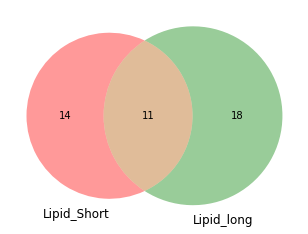

In [16]:
lipid_short_fi_set = set(lipid_short_fi[lipid_short_fi["Value"] != 0].Feature)
lipid_long_fi_set = set(lipid_long_fi[lipid_long_fi["Value"] != 0].Feature)

venn2([lipid_short_fi_set, lipid_long_fi_set], ('Lipid_Short', 'Lipid_long'))
plt.show()

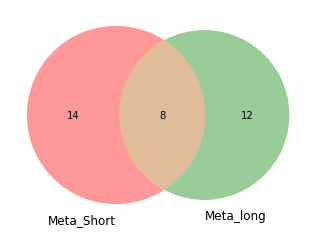

In [17]:
meta_short_fi_set = set(meta_short_fi[meta_short_fi["Value"] != 0].Feature)
meta_long_fi_set = set(meta_long_fi[meta_long_fi["Value"] != 0].Feature)

venn2([meta_short_fi_set, meta_long_fi_set], ('Meta_Short', 'Meta_long'))
plt.show()

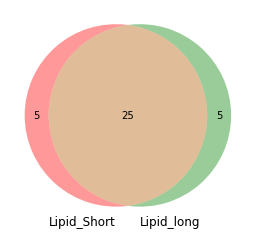

In [18]:
lipid_short_pvalue_set = set(lipid_short_pvalue[lipid_short_pvalue["P-value"] != 0].Feature.head(30))
lipid_long_pvalue_set = set(lipid_long_pvalue[lipid_long_pvalue["P-value"] != 0].Feature.head(30))

venn2([lipid_short_pvalue_set, lipid_long_pvalue_set], ('Lipid_Short', 'Lipid_long'))
plt.show()

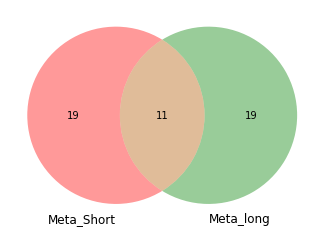

In [19]:
meta_short_pvalue_set = set(meta_short_pvalue[meta_short_pvalue["P-value"] != 0].Feature.head(30))
meta_long_pvalue_set = set(meta_long_pvalue[meta_long_pvalue["P-value"] != 0].Feature.head(30))

venn2([meta_short_pvalue_set, meta_long_pvalue_set], ('Meta_Short', 'Meta_long'))
plt.show()

## AUC of Intersected Features

In [20]:
Intersected_Feature_AUC(lipid_short, xgbc, lipid_short_fi_set, lipid_long_fi_set)

AUC of testing set: 0.9955499046408138


In [21]:
Intersected_Feature_AUC(meta_short, xgbc, meta_short_fi_set, meta_long_fi_set)

AUC of testing set: 0.9748887476160204


In [22]:
Intersected_Feature_AUC(lipid_short, lr, lipid_short_fi_set, lipid_long_fi_set)

AUC of testing set: 0.9974570883661793


In [23]:
Intersected_Feature_AUC(meta_short, lr, meta_short_fi_set, meta_long_fi_set)

AUC of testing set: 0.994596312778131


## Venn Diagram of LOOCV and 3-fold CV's Intersected Features

In [24]:
lipid_short_3fold = model_fi(lipid_short_X, lipid_short_y, lipid_short_cols, kfold)
lipid_short_3fold_auc = model_fi_auc(lipid_short_3fold, lipid_short_X, lipid_short_y, lipid_short_cols)

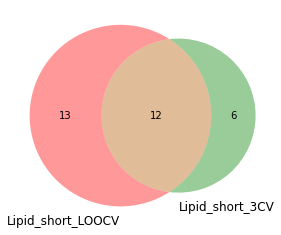

In [25]:
lipid_short_3fold_non_zero = lipid_short_3fold[lipid_short_3fold != 0]
lipid_short_3fold_non_zero = lipid_short_3fold_non_zero.dropna()

venn2([lipid_short_fi_set, set(lipid_short_3fold_non_zero.Feature)], ('Lipid_short_LOOCV', 'Lipid_short_3CV'))
plt.show()

In [26]:
lipid_long_3fold = model_fi(lipid_long_X, lipid_long_y, lipid_long_cols, kfold)
lipid_long_3fold_auc = model_fi_auc(lipid_long_3fold, lipid_long_X, lipid_long_y, lipid_long_cols)

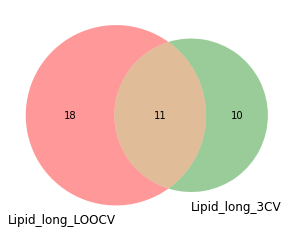

In [27]:
lipid_long_3fold_non_zero = lipid_long_3fold[lipid_long_3fold != 0]
lipid_long_3fold_non_zero = lipid_long_3fold_non_zero.dropna()

venn2([lipid_long_fi_set, set(lipid_long_3fold_non_zero.Feature)], ('Lipid_long_LOOCV', 'Lipid_long_3CV'))
plt.show()

In [28]:
meta_short_3fold = model_fi(meta_short_X, meta_short_y, meta_short_cols, kfold)
meta_short_3fold_auc = model_fi_auc(meta_short_3fold, meta_short_X, meta_short_y, meta_short_cols)

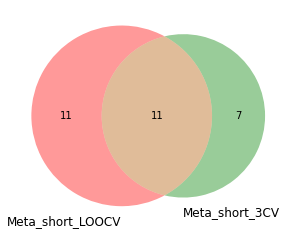

In [29]:
meta_short_3fold_non_zero = meta_short_3fold[meta_short_3fold != 0]
meta_short_3fold_non_zero = meta_short_3fold_non_zero.dropna()

venn2([meta_short_fi_set, set(meta_short_3fold_non_zero.Feature)], ('Meta_short_LOOCV', 'Meta_short_3CV'))
plt.show()

In [30]:
meta_long_3fold = model_fi(meta_long_X, meta_long_y, meta_long_cols, kfold)
meta_long_3fold_auc = model_fi_auc(meta_long_3fold, meta_long_X, meta_long_y, meta_long_cols)

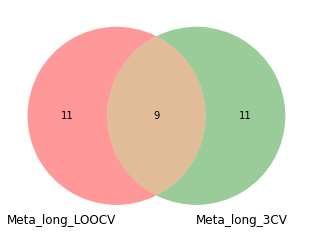

In [31]:
meta_long_3fold_non_zero = meta_long_3fold[meta_long_3fold != 0]
meta_long_3fold_non_zero = meta_long_3fold_non_zero.dropna()

venn2([meta_long_fi_set, set(meta_long_3fold_non_zero.Feature)], ('Meta_long_LOOCV', 'Meta_long_3CV'))
plt.show()

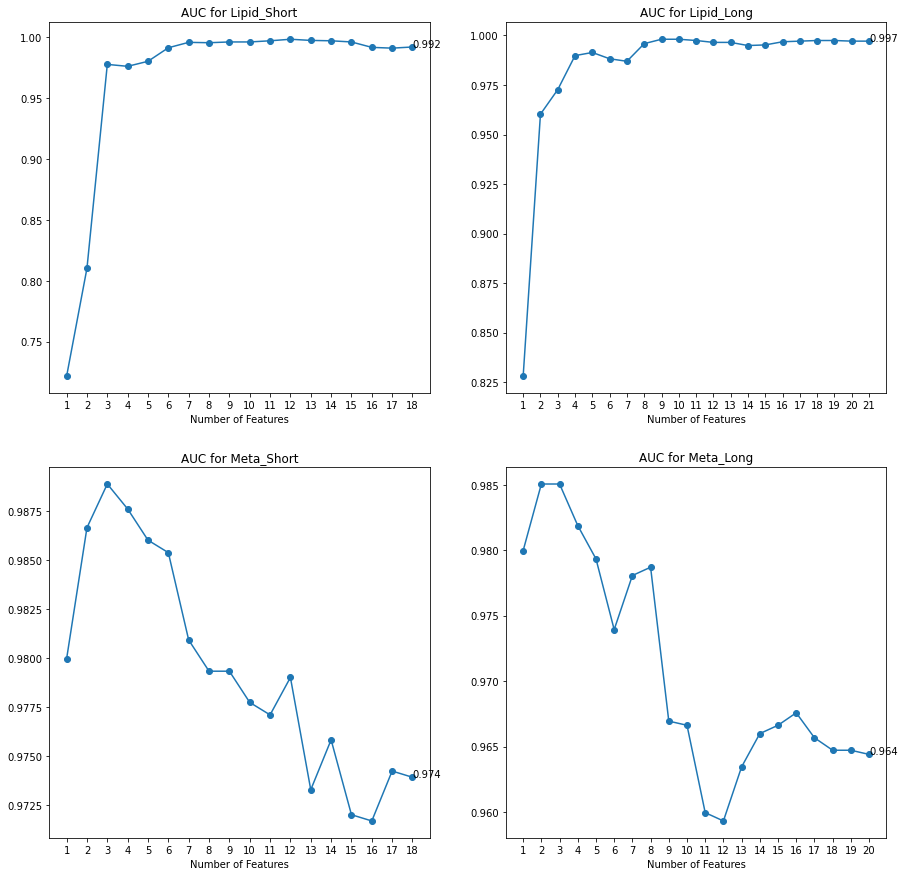

In [32]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15,15))

ax[0,0].plot(list(range(1,len(lipid_short_3fold_auc)+1)), lipid_short_3fold_auc)
ax[0,0].scatter(list(range(1,len(lipid_short_3fold_auc)+1)), lipid_short_3fold_auc)
ax[0,0].annotate(round(lipid_short_3fold_auc[-1], 3), (list(range(1,len(lipid_short_3fold_auc)+1))[-1], lipid_short_3fold_auc[-1]))
ax[0,0].title.set_text('AUC for Lipid_Short')
ax[0,0].set_xlabel('Number of Features')
ax[0,0].set_xticks(list(range(1,len(lipid_short_3fold_auc)+1))) 

ax[0,1].plot(list(range(1,len(lipid_long_3fold_auc)+1)), lipid_long_3fold_auc)
ax[0,1].scatter(list(range(1,len(lipid_long_3fold_auc)+1)), lipid_long_3fold_auc)
ax[0,1].annotate(round(lipid_long_3fold_auc[-1], 3), (list(range(1,len(lipid_long_3fold_auc)+1))[-1], lipid_long_3fold_auc[-1]))
ax[0,1].title.set_text('AUC for Lipid_Long')
ax[0,1].set_xlabel('Number of Features')
ax[0,1].set_xticks(list(range(1,len(lipid_long_3fold_auc)+1))) 

ax[1,0].plot(list(range(1,len(meta_short_3fold_auc)+1)), meta_short_3fold_auc)
ax[1,0].scatter(list(range(1,len(meta_short_3fold_auc)+1)), meta_short_3fold_auc)
ax[1,0].annotate(round(meta_short_3fold_auc[-1], 3), (list(range(1,len(meta_short_3fold_auc)+1))[-1], meta_short_3fold_auc[-1]))
ax[1,0].title.set_text('AUC for Meta_Short')
ax[1,0].set_xlabel('Number of Features')
ax[1,0].set_xticks(list(range(1,len(meta_short_3fold_auc)+1))) 

ax[1,1].plot(list(range(1,len(meta_long_3fold_auc)+1)), meta_long_3fold_auc)
ax[1,1].scatter(list(range(1,len(meta_long_3fold_auc)+1)), meta_long_3fold_auc)
ax[1,1].annotate(round(meta_long_3fold_auc[-1], 3), (list(range(1,len(meta_long_3fold_auc)+1))[-1], meta_long_3fold_auc[-1]))
ax[1,1].title.set_text('AUC for Meta_Long')
ax[1,1].set_xlabel('Number of Features')
ax[1,1].set_xticks(list(range(1,len(meta_long_3fold_auc)+1))) 

plt.show()

In [33]:
lipid_short_3fold["AUC"] = pd.Series(lipid_short_3fold_auc)
lipid_short_3fold["AUC"][lipid_short_3fold["AUC"].isna()]= ""
lipid_long_3fold["AUC"] = pd.Series(lipid_long_3fold_auc)
lipid_long_3fold["AUC"][lipid_long_3fold["AUC"].isna()]= ""
meta_short_3fold["AUC"] = pd.Series(meta_short_3fold_auc)
meta_short_3fold["AUC"][meta_short_3fold["AUC"].isna()]= ""
meta_long_3fold["AUC"] = pd.Series(meta_long_3fold_auc)
meta_long_3fold["AUC"][meta_long_3fold["AUC"].isna()]= ""

In [34]:
fold_df = pd.concat([lipid_short_3fold, lipid_long_3fold, meta_short_3fold, meta_long_3fold], axis=1)
fold_df[fold_df.isna()] = ""
fold_df.columns = ["Lipid_Short_Feature_Name", "Lipid_Short_Feature_Importance", "Lipid_Short_Accumulated_AUC",
                "Lipid_Long_Feature_Name", "Lipid_Long_Feature_Importance", "Lipid_Long_Accumulated_AUC",
                "Meta_Short_Feature_Name", "Meta_Short_Feature_Importance", "Meta_Short_Accumulated_AUC",
                "Meta_Long_Feature_Name", "Meta_Long_Feature_Importance", "Meta_Long_Accumulated_AUC"]
#fold_df.to_csv("Feature_importance_3fold.csv")